##  Άσκηση 1 – Δημιουργία Προγράμματος Διδασκαλίας

Στόχος της άσκησης είναι να δημιουργηθεί ένα εβδομαδιαίο πρόγραμμα διδασκαλίας χωρίς επικαλύψεις, εξασφαλίζοντας ότι κάθε διδάσκων βρίσκεται μόνο σε ένα τμήμα κάθε στιγμή και ότι καλύπτονται όλες οι απαιτούμενες ώρες.

Αρχικά γίνεται εγκατάσταση των απαραίτητων βιβλιοθηκών και η εισαγωγή της βιβλιοθήκης Gurobi, κατάλληλη για μοντελοποίηση προβλημάτων βελτιστοποίησης, ενώ γίνεται και  χρήση της quicksum για άθροιση όρων μέσα στο μοντέλο.

In [66]:
!pip install gurobipy
from gurobipy import Model, GRB, quicksum
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Στην συνέχεια αποτυπώνονται τα δεδομένα που απαιτούνται για την αυτόματη δημιουργία ενός εβδομαδιαίου προγράμματος διδασκαλίας για δύο τμήματα ενός σχολείου.

Ορίζονται οι **μέρες της εβδομάδας** κατά τις οποίες διεξάγονται τα μαθήματα, καθορίζονται τα **διαστήματα ωρών διδασκαλίας** που είναι διαθέσιμα, ενώ τέλος, παρουσιάζονται τα **μαθήματα**, οι **διδάσκοντες**, καθώς και οι **ώρες διδασκαλίας** που απαιτούνται για κάθε μάθημα ανά τμήμα.

**Να σημειωθεί** ότι στα εβδομαδιαία μαθήματα έχουν προστεθεί τα ΟργάνωσηΜελέτης1 και ΟργάνωσηΜελέτης2, καθώς ζητάται να προγραμματιστούν για την πρώτη χρονική ζώνη το πρωί της Δευτέρας και για τα δύο τμήματα.

In [67]:
days = ['Δευτέρα', 'Τρίτη', 'Τετάρτη', 'Πέμπτη', 'Παρασκευή']
slots = ['08:00-10:00', '10:15-12:15', '14:00-16:00', '16:15-18:15']
timetable = [(d, s) for d in days for s in slots]
types = [1, 2]

courses = {
    'Αγγλικά': {'Καθηγητής': 'Γεσμανιδης', 'Τμήμα1': 1, 'Τμήμα2': 1},
    'Βιολογία': {'Καθηγητής': 'Ινσουλίνα', 'Τμήμα1': 3, 'Τμήμα2': 3},
    'Ιστορία-Γεωγραφία': {'Καθηγητής': 'Χαρτούλα', 'Τμήμα1': 2, 'Τμήμα2': 2},
    'Μαθηματικά1': {'Καθηγητής': 'Αντιπαράγωγος', 'Τμήμα1': 4, 'Τμήμα2': 0},
    'Μαθηματικά2': {'Καθηγητής': 'Λαθοπράξης', 'Τμήμα1': 0, 'Τμήμα2': 4},
    'Φυσική': {'Καθηγητής': 'Κιρκοφίδου', 'Τμήμα1': 3, 'Τμήμα2': 3},
    'Φιλοσοφία': {'Καθηγητής': 'Πλατιάζων', 'Τμήμα1': 1, 'Τμήμα2': 1},
    'ΦυσικήΑγωγή1': {'Καθηγητής': 'Μπρατσάκης', 'Τμήμα1': 1, 'Τμήμα2': 0},
    'ΦυσικήΑγωγή2': {'Καθηγητής': 'Τρεχαλητούλα', 'Τμήμα1': 0, 'Τμήμα2': 1},
    'ΟργάνωσηΜελέτης1': {'Τμήμα1': 1, 'Τμήμα2': 0},
    'ΟργάνωσηΜελέτης2': {'Τμήμα1': 0, 'Τμήμα2': 1},
}

Δημιουργείται το μοντέλο Gurobi, καθώς ορίζεται η μεταβλητή απόφασης x[c, d, s, t], που δηλώνει αν το μάθημα c γίνεται την ημέρα d, ώρα s, στο τμήμα t.

In [68]:
model = Model('Πρόγραμμα Μαθημάτων')
x = model.addVars(courses.keys(), days, slots, types, vtype=GRB.BINARY, name="x")

##  Περιορισμοί του Προβλήματος

Η διαμόρφωση του εβδομαδιαίου προγράμματος περιλαμβάνει διάφορους περιορισμούς, ώστε να εξασφαλίζεται η λειτουργικότητα και η ρεαλιστικότητα του τελικού χρονοδιαγράμματος.
Οι περιορισμοί που επιβάλλονται είναι οι εξής:

### 1. Κάλυψη απαιτούμενων ωρών διδασκαλίας
Κάθε μάθημα πρέπει να διδάσκεται όσες φορές απαιτείται για κάθε τμήμα. 

### 2. Αποφυγή επανάληψης μαθήματος την ίδια ημέρα
Δεν επιτρέπεται το ίδιο μάθημα να διδάσκεται πάνω από μία φορά την ίδια ημέρα για το ίδιο τμήμα.

### 3. Ένα μάθημα ανά slot ανά τμήμα
Κάθε τμήμα μπορεί να παρακολουθεί το πολύ **ένα μάθημα ανά slot**, προκειμένου να αποφεύγονται επικαλύψεις.

### 4. Ειδικός περιορισμός: Φυσική Αγωγή
Τα μαθήματα **Φυσικής Αγωγής** (και για τα δύο τμήματα) προγραμματίζονται **αποκλειστικά την Πέμπτη, 14:00–16:00**, όπως ορίζεται από τον κανονισμό του σχολείου.

### 5. Κενή ώρα: Δευτέρα 08:00–10:00
Η πρώτη χρονική ζώνη της Δευτέρας είναι **δεσμευμένη ως κενή**, δηλαδή δεν διδάσκεται κανένα μάθημα εκείνη για να οργανώνεται η μελέτη της εβδομάδας.

### 6. Απουσίες καθηγητών
Ορισμένοι καθηγητές δεν διδάσκουν σε συγκεκριμένες ημέρες ή ώρες, και αυτές οι απουσίες λαμβάνονται υπόψη στο πρόγραμμα:

- **Καθηγητής "Λαθοπράξης"** (Μαθηματικά 2): **Δεν διδάσκει τη Δευτέρα στις 08:00–10:00**.
- **Καθηγήτρια "Ινσουλίνα"** (Βιολογία): **Απουσιάζει κάθε Τετάρτη**, οπότε δεν μπορεί να διδάξει καμία χρονική ζώνη εκείνη την ημέρα.

### 7. Αποφυγή ταυτόχρονης διδασκαλίας στο ίδιο μάθημα
Ένα μάθημα **δεν επιτρέπεται να διδάσκεται ταυτόχρονα και στα δύο τμήματα**, καθώς οι καθηγητές (εκτός Μαθηματικών/Φυσικής Αγωγής) είναι κοινοί.

### 8. Αποφυγή κενού ανάμεσα σε δύο μαθήματα
Δεν επιτρέπεται να υπάρχουν **ενδιάμεσα κενά** μεταξύ δύο μαθημάτων την ίδια μέρα. 

### 9. Κάθε μέρα να ξεκινάει απο την πρώτη χρονική ζώνη
Εάν δεν υπάρχει μάθημα στο πρώτο διαθέσιμο slot, τότε **δεν μπορεί να ξεκινήσει μάθημα αργότερα** μέσα στην ίδια ημέρα. Έτσι αποφεύγονται ασυνέχειες στο πρόγραμμα.

In [69]:
x = {}
for c in courses:
    for d in days:
        for s in slots:
            for t in types:
                x[c, d, s, t] = model.addVar(vtype=GRB.BINARY, name=f"x_{c}_{d}_{s}_T{t}")

for c, data in courses.items():
    for t in types:
        required = data[f'Τμήμα{t}']
        model.addConstr(quicksum(x[c, d, s, t] for d in days for s in slots) == required)

for c in courses:
    for d in days:
        for t in types:
            model.addConstr(quicksum(x[c, d, s, t] for s in slots) <= 1)

for d in days:
    for s in slots:
        for t in types:
            model.addConstr(quicksum(x[c, d, s, t] for c in courses) <= 1)

for c in ['ΦυσικήΑγωγή1', 'ΦυσικήΑγωγή2']:
    for d in days:
        for s in slots:
            if not (d == 'Πέμπτη' and s == '14:00-16:00'):
                for t in types:
                    model.addConstr(x[c, d, s, t] == 0)

for c in courses:
    if c not in ['ΟργάνωσηΜελέτης1', 'ΟργάνωσηΜελέτης2']:
        for t in types:
            model.addConstr(x[c, 'Δευτέρα', '08:00-10:00', t] == 0)

model.addConstr(x['Μαθηματικά2', 'Δευτέρα', '08:00-10:00', 2] == 0)

for s in slots:
    for t in types:
        model.addConstr(x['Βιολογία', 'Τετάρτη', s, t] == 0)

for c in courses:
    for d in days:
        for s in slots:
            model.addConstr(x[c, d, s, 1] + x[c, d, s, 2] <= 1)

for t in types:       
    for d in days:
        for i in range(1, len(slots)-1): 
            prev_slot = slots[i-1]
            curr_slot = slots[i]
            next_slot = slots[i+1]

            model.addConstr(
                gp.quicksum(x[c, d, prev_slot, t] for c in courses) +
                gp.quicksum(x[c, d, next_slot, t] for c in courses) -
                gp.quicksum(x[c, d, curr_slot, t] for c in courses) <= 1,
                name=f"no_gap_{t}_{d}_{curr_slot}"
            )

for t in types:
    for d in days:
        for j in range(1, len(slots)):
            model.addConstr(
                gp.quicksum(x[c, d, slots[j], t] for c in courses) <=
                gp.quicksum(x[c, d, slots[j-1], t] for c in courses),
                name=f"no_gap_start_{t}_{d}_{slots[j]}"
            )


## Επίλυση του Προβλήματος

Αφού έχουν οριστεί όλοι οι περιορισμοί του προβλήματος, καθορίζουμε την αντικειμενική συνάρτηση και επιλύουμε το μοντέλο.

Πρόκειται για **πρόβλημα εφικτότητας**, δηλαδή το ζητούμενο είναι να βρεθεί ένας συνδυασμός ημερών και ωρών που να ικανοποιεί όλους τους περιορισμούς, οπότε δεν υπάρχει κάποιος ποσοτικός στόχος που να χρειάζεται βελτιστοποίηση. Επομένως ορίζεται μια **μηδενική αντικειμενική συνάρτηση** και καλείται ο Gurobi για να προσπαθήσει να βρει μία εφικτή λύση.


In [70]:
model.setObjective(0, GRB.MINIMIZE)
model.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 545 rows, 880 columns and 3183 nonzeros
Model fingerprint: 0xa0ed46c0
Variable types: 0 continuous, 880 integer (880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 337 rows and 650 columns
Presolve time: 0.01s
Presolved: 208 rows, 230 columns, 1320 nonzeros
Variable types: 0 continuous, 230 integer (230 binary)

Root relaxation: objective 0.000000e+00, 90 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                 

## Τελική Μορφή Ωρολογίου Προγράμματος Ανά Τμήμα

Αφού βρεθεί μια εφικτή λύση που ικανοποιεί όλους τους περιορισμούς, προχωράμε στην παρουσίαση του αποτελέσματος. Για κάθε τμήμα, εμφανίζουμε αναλυτικά το πρόγραμμα διδασκαλίας, οργανωμένο ανά ημέρα και ζώνη ώρας.

In [71]:
for t in types:
    print(f"\nΤμήμα {t}")
    for d in days:
        print(f"  {d}")
        for s in slots:
            if d == 'Δευτέρα' and s == '08:00-10:00':
                print(f"    {s}: Οργάνωση Μελέτης της Εβδομάδας")
                continue
            for c in courses:
                if x[c, d, s, t].X > 0.5:
                    print(f"    {s}: {c}")                    



Τμήμα 1
  Δευτέρα
    08:00-10:00: Οργάνωση Μελέτης της Εβδομάδας
    10:15-12:15: Μαθηματικά1
    14:00-16:00: Βιολογία
    16:15-18:15: Ιστορία-Γεωγραφία
  Τρίτη
    08:00-10:00: Φυσική
    10:15-12:15: Βιολογία
    14:00-16:00: Φιλοσοφία
  Τετάρτη
    08:00-10:00: Μαθηματικά1
    10:15-12:15: Ιστορία-Γεωγραφία
  Πέμπτη
    08:00-10:00: Φυσική
    10:15-12:15: Μαθηματικά1
    14:00-16:00: ΦυσικήΑγωγή1
    16:15-18:15: Αγγλικά
  Παρασκευή
    08:00-10:00: Φυσική
    10:15-12:15: Βιολογία
    14:00-16:00: Μαθηματικά1

Τμήμα 2
  Δευτέρα
    08:00-10:00: Οργάνωση Μελέτης της Εβδομάδας
    10:15-12:15: Μαθηματικά2
    14:00-16:00: Φυσική
    16:15-18:15: Βιολογία
  Τρίτη
    08:00-10:00: Μαθηματικά2
    10:15-12:15: Ιστορία-Γεωγραφία
  Τετάρτη
    08:00-10:00: Φυσική
    10:15-12:15: Αγγλικά
    14:00-16:00: Μαθηματικά2
  Πέμπτη
    08:00-10:00: Βιολογία
    10:15-12:15: Μαθηματικά2
    14:00-16:00: ΦυσικήΑγωγή2
  Παρασκευή
    08:00-10:00: Φιλοσοφία
    10:15-12:15: Ιστορία-Γεωγραφία
  

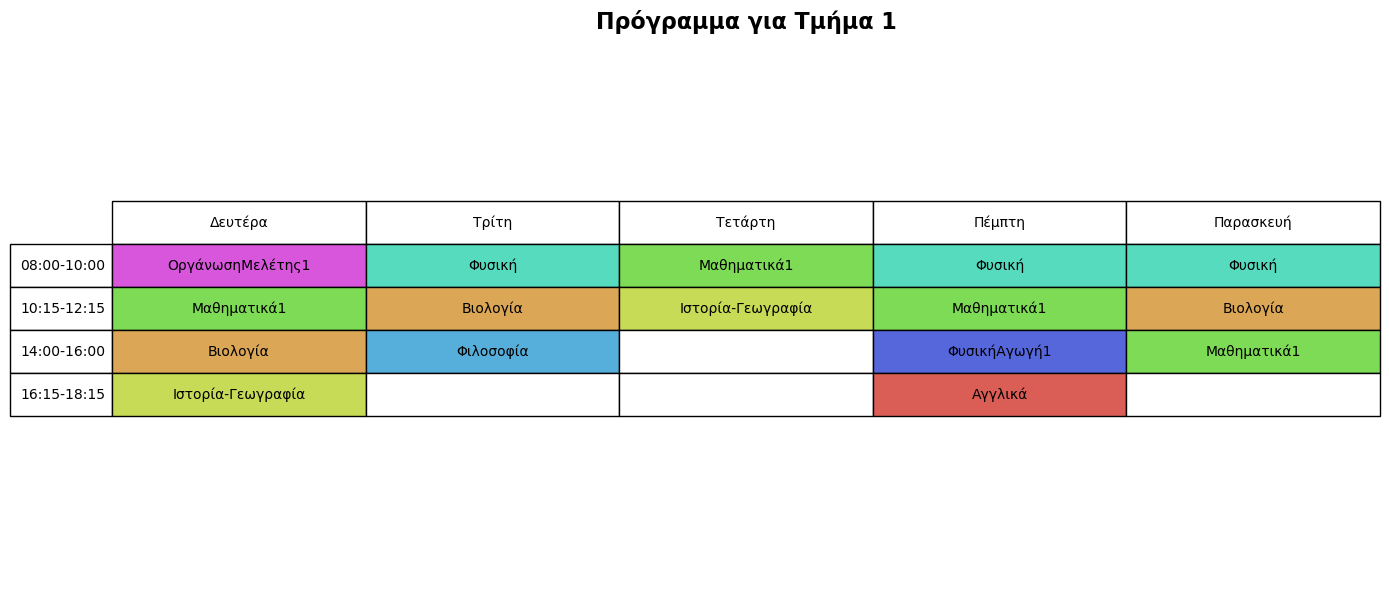

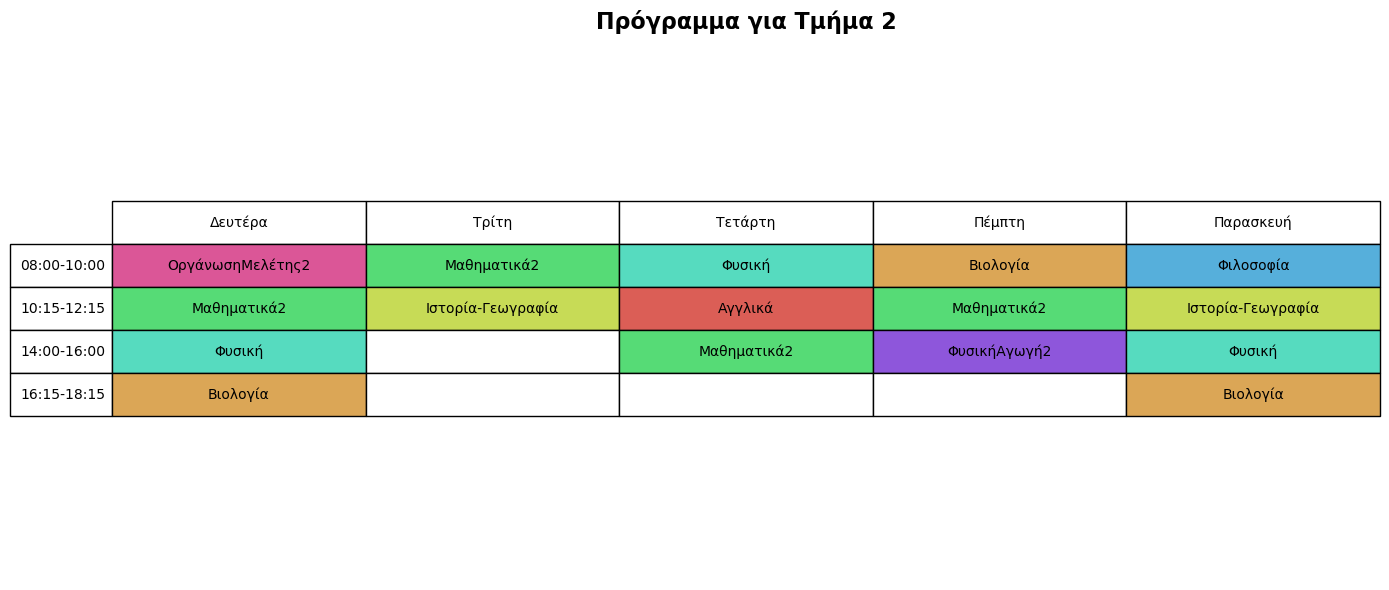

In [72]:
def visualize_schedule(x, courses, days, slots, types):
    color_map = sns.color_palette("hls", len(courses))  
    course_colors = {course: color_map[i] for i, course in enumerate(courses)}

    for t in types:
        fig, ax = plt.subplots(figsize=(14, 6))
        timetable = pd.DataFrame('', index=slots, columns=days)

        for c in courses:
            for d in days:
                for s in slots:
                    if x[c, d, s, t].X > 0.5:
                        timetable.loc[s, d] = c 

        cmap = {course: f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
                for course, (r, g, b) in course_colors.items()}

        colors = timetable.copy()
        for r in colors.index:
            for c_ in colors.columns:
                course_name = colors.loc[r, c_]
                colors.loc[r, c_] = cmap.get(course_name, '#ffffff')

        table = ax.table(cellText=timetable.values,
                         cellColours=colors.values,
                         rowLabels=slots,
                         colLabels=days,
                         loc='center',
                         cellLoc='center')

        table.scale(1, 2.2)
        ax.axis('off')
        ax.set_title(f'Πρόγραμμα για Τμήμα {t}', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()
visualize_schedule(x, courses, days, slots, types)

## Τελική Μορφή Ωρολογίου Προγράμματος Ανά Καθηγητή

Τέλος για κάθε καθηγητή, εμφανίζουμε αναλυτικά το πρόγραμμα διδασκαλίας του σε κάθε τμήμα, οργανωμένο ανά ημέρα και ζώνη ώρας.

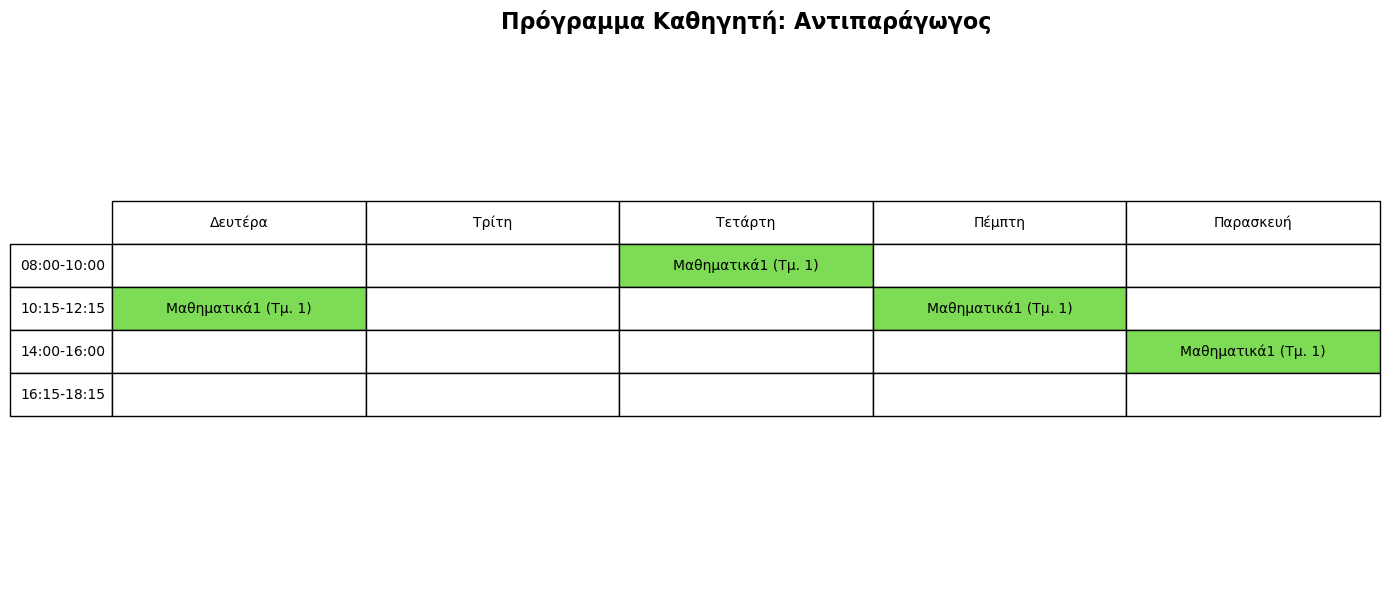

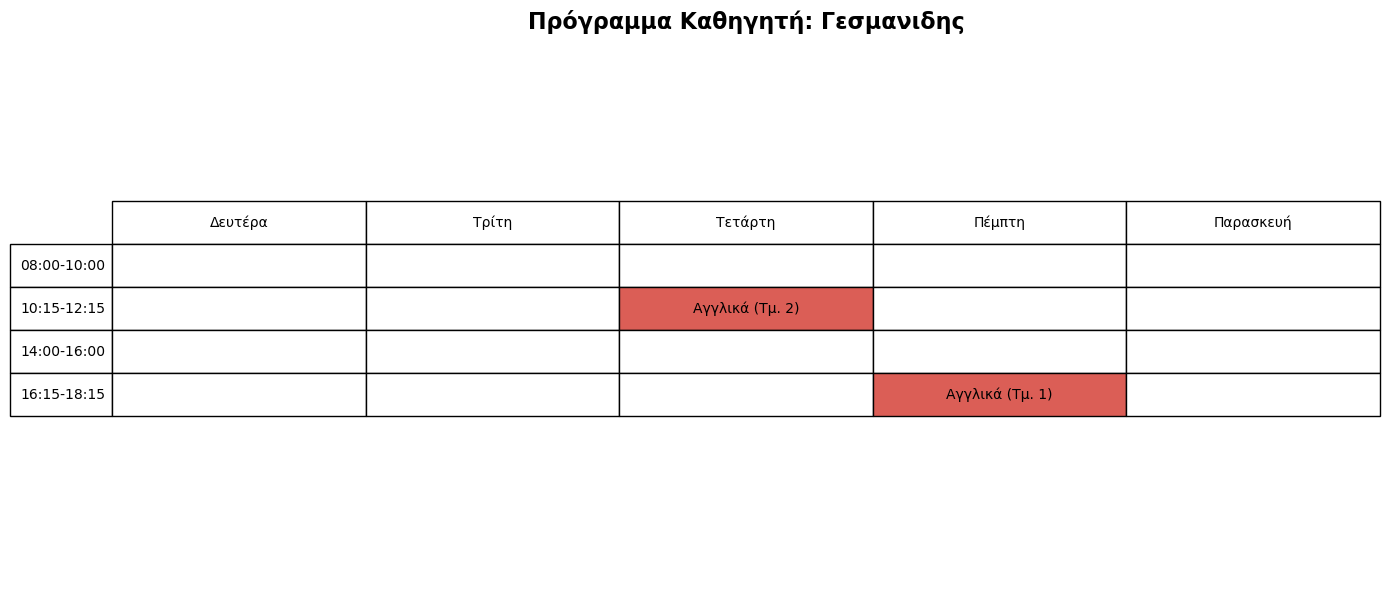

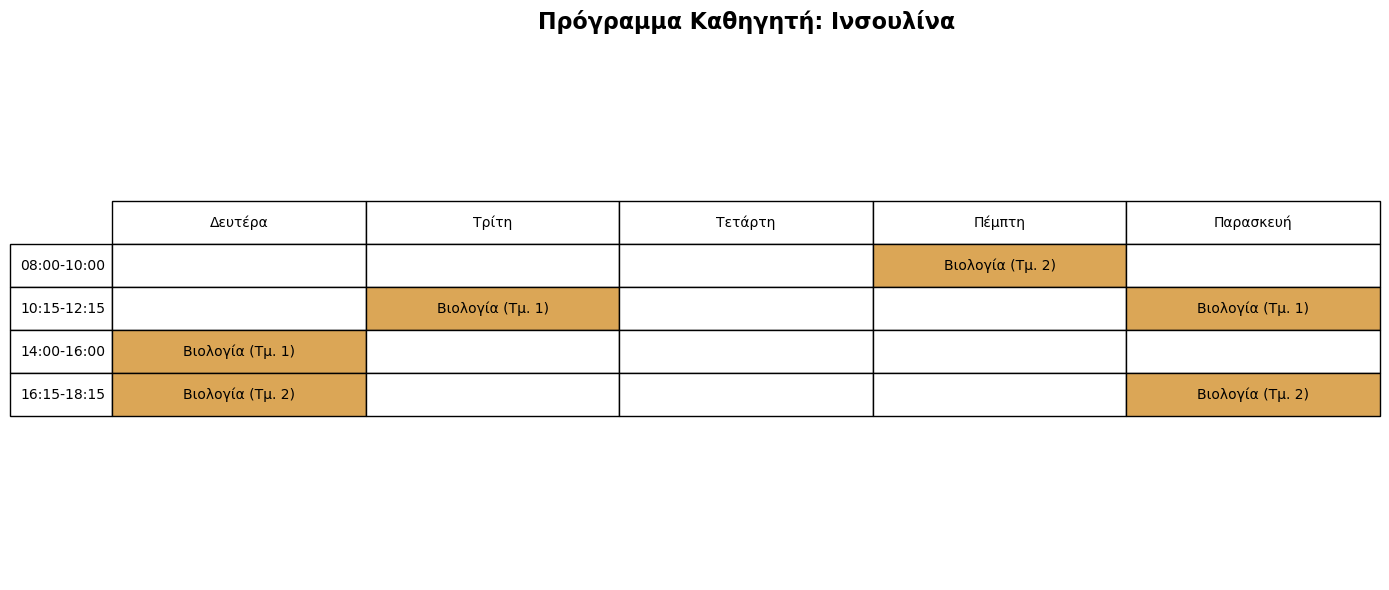

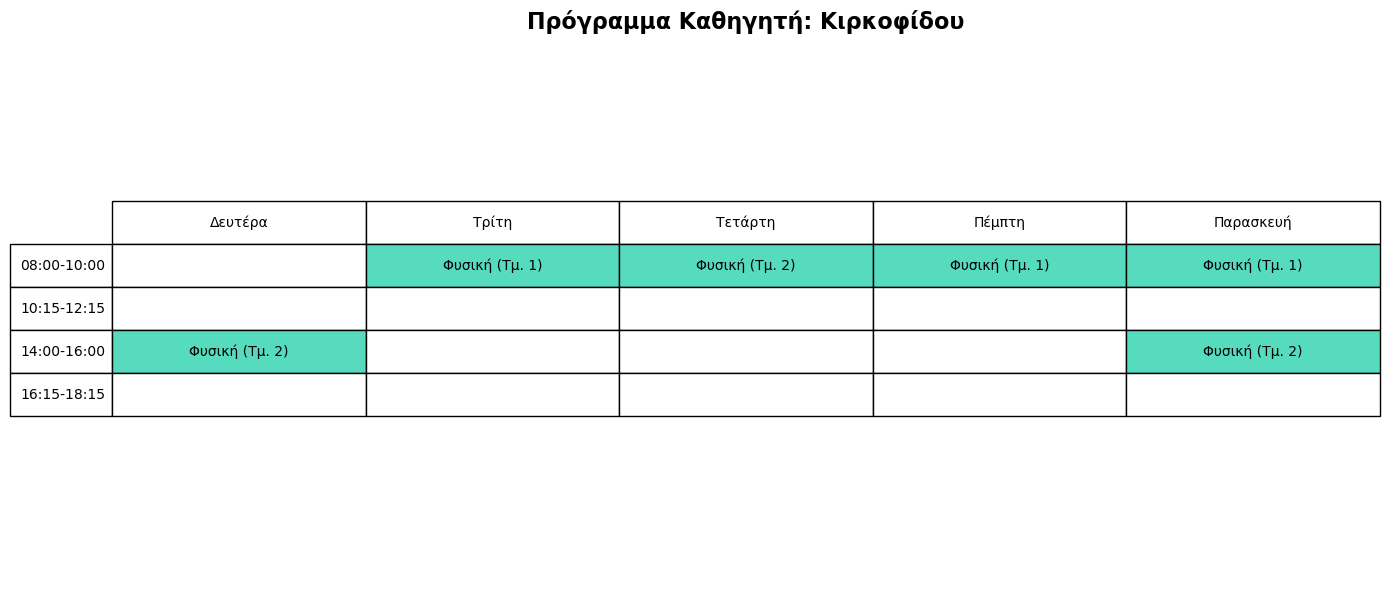

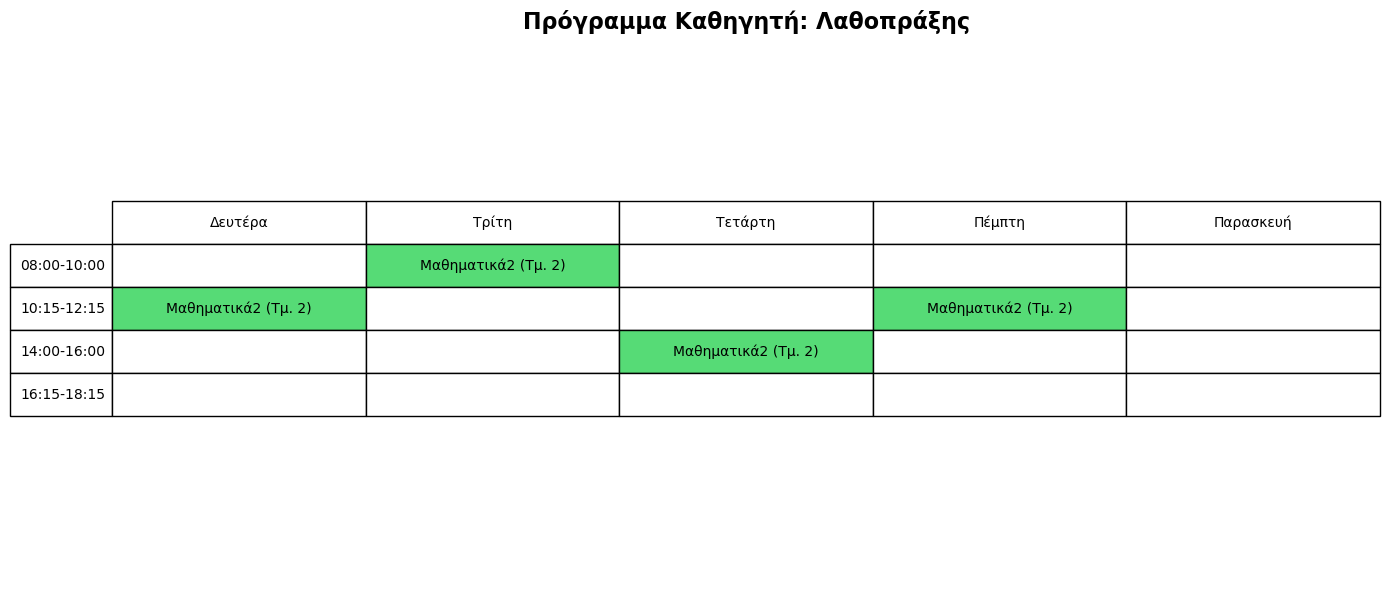

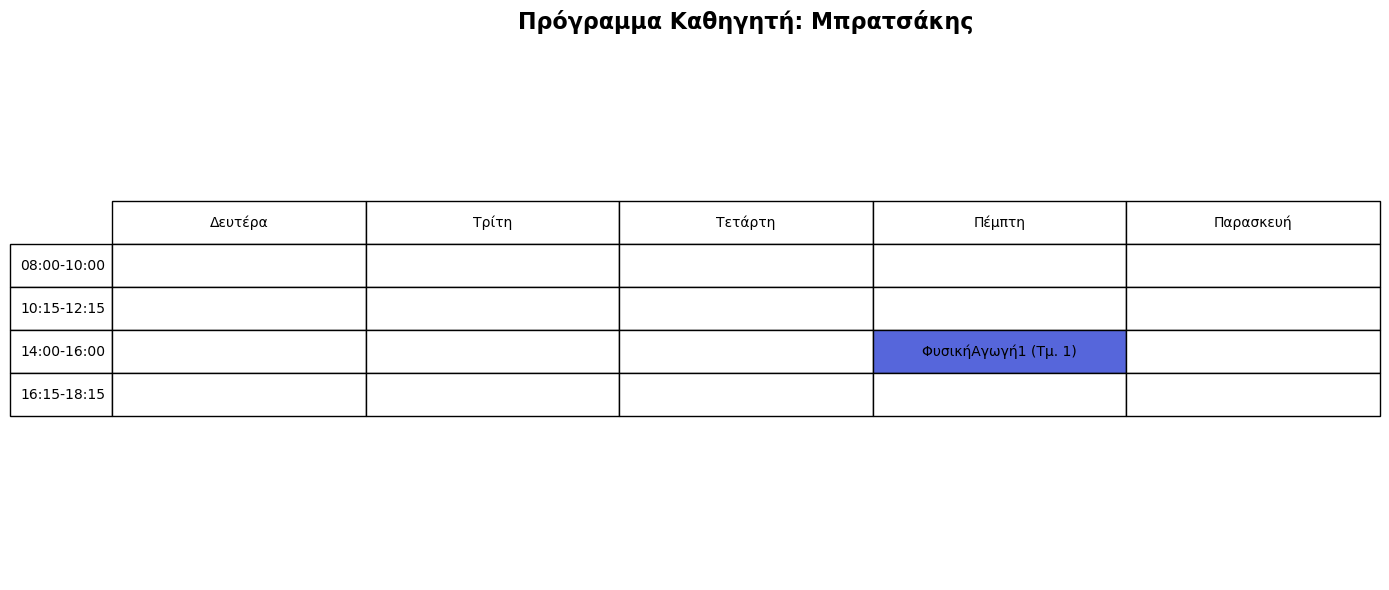

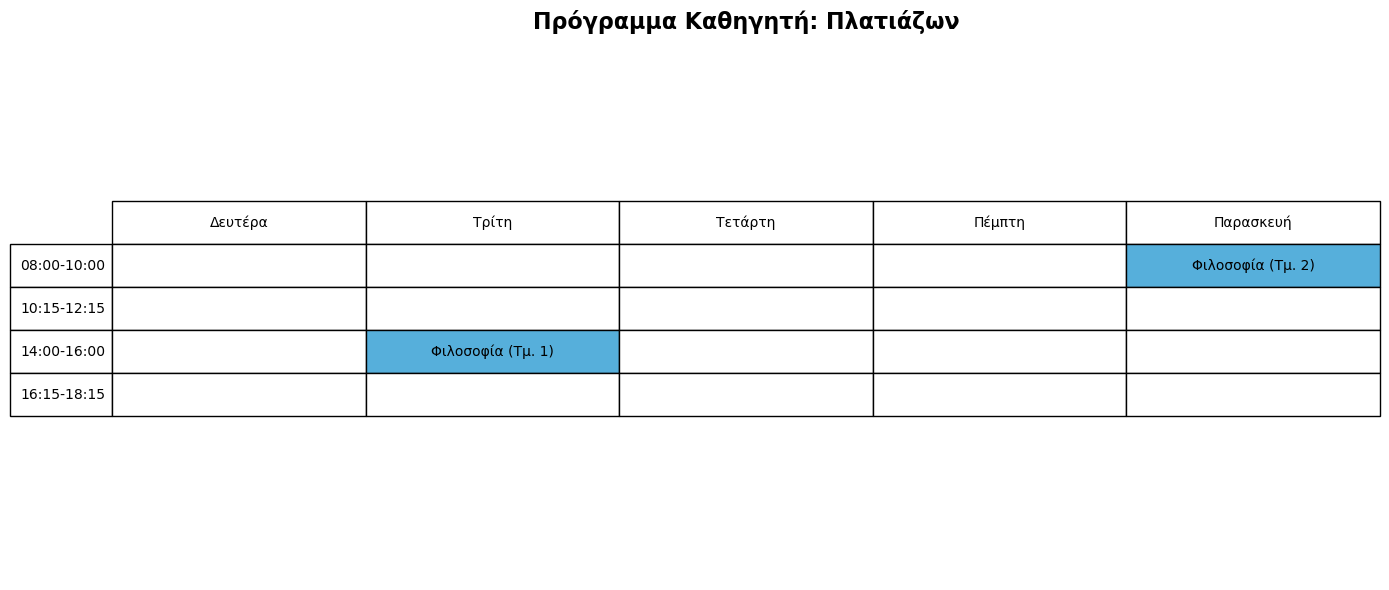

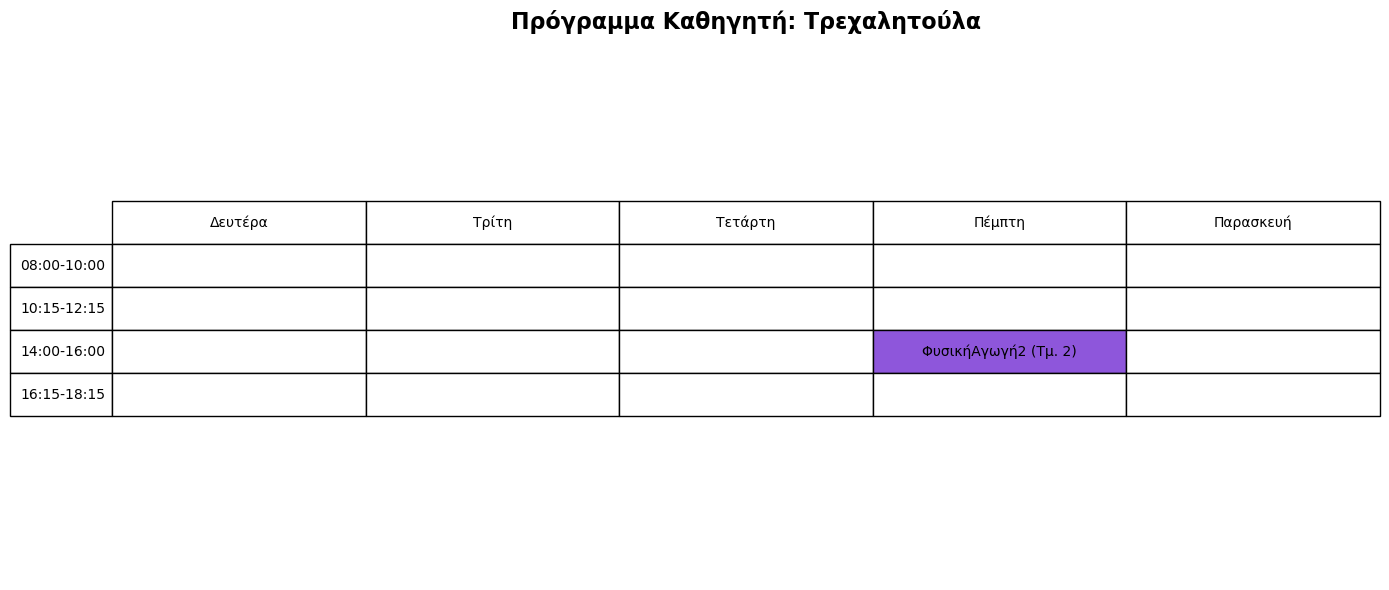

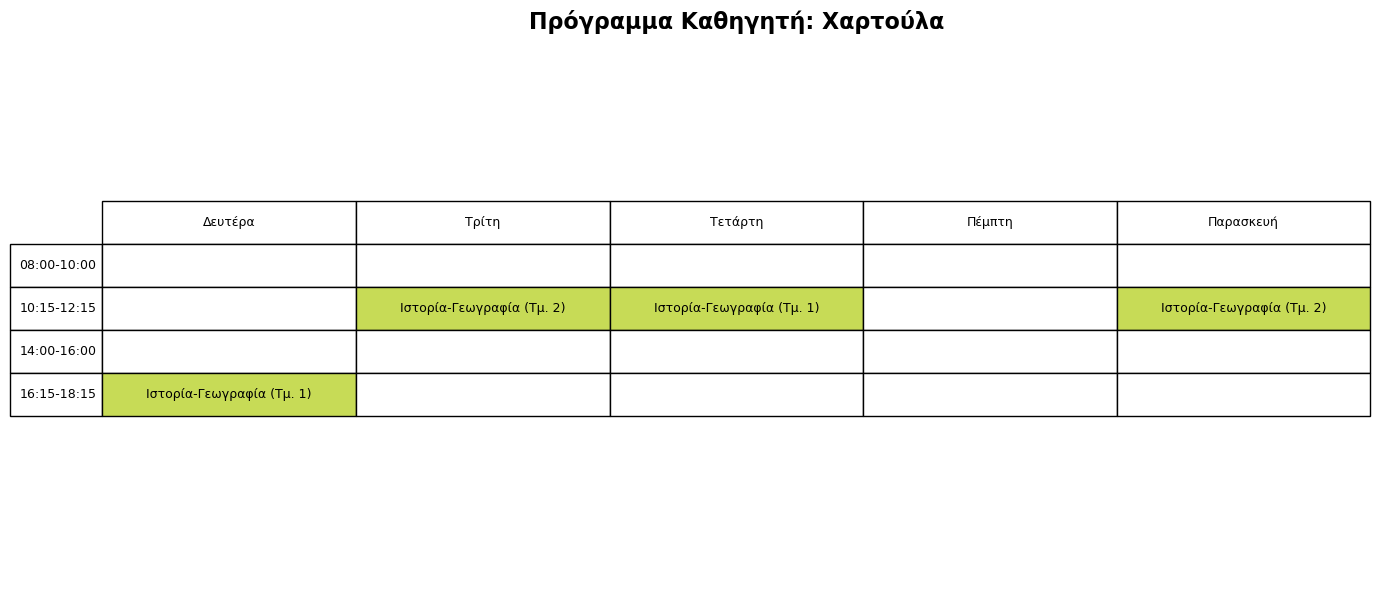

In [73]:
def visualize_teacher_schedules(x, courses, days, slots, types):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Βρες όλους τους καθηγητές
    teacher_per_course = {c: data.get('Καθηγητής', None) for c, data in courses.items() if 'Καθηγητής' in data}
    all_teachers = sorted(set(t for t in teacher_per_course.values() if t is not None))
    
    color_map = sns.color_palette("hls", len(courses))  
    course_colors = {course: color_map[i] for i, course in enumerate(courses)}
    cmap = {course: f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" 
            for course, (r, g, b) in course_colors.items()}

    for teacher in all_teachers:
        fig, ax = plt.subplots(figsize=(14, 6))
        timetable = pd.DataFrame('', index=slots, columns=days)
        colors = pd.DataFrame('#ffffff', index=slots, columns=days)

        found_any = False
        for c in courses:
            if teacher_per_course.get(c) != teacher:
                continue
            for d in days:
                for s in slots:
                    for t in types:
                        if x[c, d, s, t].X > 0.5:
                            timetable.loc[s, d] = f"{c} (Τμ. {t})"
                            colors.loc[s, d] = cmap.get(c, '#ffffff')
                            found_any = True
        
        if not found_any:
            print(f"Ο καθηγητής {teacher} δεν έχει προγραμματισμένα μαθήματα.")
            plt.close(fig)
            continue
        
        table = ax.table(cellText=timetable.values,
                         cellColours=colors.values,
                         rowLabels=slots,
                         colLabels=days,
                         loc='center',
                         cellLoc='center')

        table.scale(1, 2.2)
        ax.axis('off')
        ax.set_title(f'Πρόγραμμα Καθηγητή: {teacher}', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()

# Κάλεσε την συνάρτηση:
visualize_teacher_schedules(x, courses, days, slots, types)

##  Άσκηση 2 – Βέλτιστη Χωροθέτηση Αποθηκών

## Περιγραφή 

Η δεύτερη άσκηση πραγματεύεται το πρόβλημα **εγκατάστασης αποθηκών**. Ο στόχος είναι να επιλέξουμε ποιες αποθήκες θα λειτουργήσουν και πώς θα εξυπηρετήσουν τα κέντρα πώλησης, ώστε να καλυφθεί πλήρως η ζήτηση κάθε κέντρου με το **ελάχιστο δυνατό συνολικό κόστος**.

Κάθε αποθήκη έχει:

- **Πάγιο κόστος λειτουργίας**
- **Μέγιστη χωρητικότητα**

Κάθε κέντρο πώλησης έχει:

- **Καθορισμένη ζήτηση**

Η μεταφορά προϊόντων από αποθήκες σε κέντρα πώλησης έχει μεταφορικό κόστος, το οποίο εξαρτάται από την απόσταση.

## Σκοπός 

Να ελαχιστοποιηθεί το **συνολικό κόστος**, το οποίο αποτελείται από:
- Τα **κόστη εγκατάστασης** αποθηκών, και
- Τα **κόστη μεταφοράς** αγαθών από τις αποθήκες στα κέντρα πώλησης.

Σε αυτό το σημείο ξεκινάμε με την υλοποίηση του μοντέλου βελτιστοποίησης, εισάγοντας βιβλιοθήκες όπως:

- `from gurobipy import Model, GRB, quicksum`

  Εισάγονται τα βασικά εργαλεία της βιβλιοθήκης **Gurobi**:

  - `Model`: για τη δημιουργία του μαθηματικού μοντέλου.

  - `GRB`: για τη χρήση σταθερών τύπων.

  - `quicksum`: για αποδοτική άθροιση όρων σε περιορισμούς ή στην αντικειμενική συνάρτηση.

- `import numpy as np`

  Για να χειριστούμε πίνακες κόστους, ζήτησης και χωρητικότητας με αποδοτικό και ευέλικτο τρόπο.

- `import pandas as pd`

  Για να φτιάξουμε πίνακες με τα δεδομένα αποθηκών, αναθέσεων, κάλυψης ζήτησης και να παρουσιάσουμε τα αποτελέσματα πιο καθαρά και οργανωμένα.

- `import seaborn as sns`

    Για τη **γραφή heatmaps**

- `import matplotlib.pyplot as plt`

    Για τη δημιουργία γραφημάτων.

In [74]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## Εισαγωγή Δεδομένων του Προβλήματος

Τώρα ορίζονται τα βασικά δεδομένα που απαιτούνται για την επίλυση του προβλήματος χωροθέτησης αποθηκών:

- `costs`: Πίνακας με τα κόστη μεταφοράς ανά μονάδα προϊόντος από κάθε αποθήκη προς κάθε κέντρο πώλησης. Τιμές `float('inf')` δηλώνουν ότι η μεταφορά δεν είναι δυνατή.
  
- `fixed_costs`: Πίνακας με τα πάγια κόστη λειτουργίας κάθε αποθήκης. Το κόστος αυτό προστίθεται μόνο αν η αποθήκη επιλεγεί για λειτουργία.
  
- `capacities`: Μέγιστη χωρητικότητα κάθε αποθήκης, δηλαδή πόσους συνολικά τόνους μπορεί να διαχειριστεί.

- `demands`: Ζήτηση (σε τόνους) κάθε κέντρου πώλησης. Η ζήτηση αυτή πρέπει να καλυφθεί εξ ολοκλήρου από τις επιλεγμένες αποθήκες.

Τα δεδομένα αυτά αποτελούν τη βάση πάνω στην οποία θα διαμορφωθεί το μαθηματικό μοντέλο, λαμβάνοντας υπόψη τους περιορισμούς χωρητικότητας, διαθεσιμότητας και κόστους.


In [75]:
costs = [
    [100, 80, 50, 50, 60, 100, 120, 90, 60, 70, 65, 110],
    [120, 90, 60, 70, 65, 110, 140, 110, 80, 80, 75, 130],
    [140, 110, 80, 80, 75, 130, 160, 125, 100, 100, 80, 150],
    [160, 125, 100, 100, 80, 150, 190, 150, 130, float('inf'), float('inf'), float('inf')],
    [190, 150, 130, float('inf'), float('inf'), float('inf'), 180, 150, 50, 50, 60, 100],
    [200, 180, 150, float('inf'), float('inf'), float('inf'), 100, 120, 90, 60, 75, 110],
    [120, 90, 60, 70, 65, 110, 140, 110, 80, 80, 75, 130],
    [120, 90, 60, 70, 65, 110, 140, 110, 80, 80, 75, 130],
    [140, 110, 80, 80, 75, 130, 160, 125, 100, 100, 80, 150],
    [160, 125, 100, 100, 80, 150, 190, 150, 130, float('inf'), float('inf'), float('inf')],
    [190, 150, 130, float('inf'), float('inf'), float('inf'), 200, 180, 150, float('inf'), float('inf'), float('inf')],
    [200, 180, 150, float('inf'), float('inf'), float('inf'), 100, 80, 50, 50, 60, 100]
]

fixed_costs = [3500, 9000, 10000, 4000, 3000, 9000, 9000, 3000, 4000, 10000, 9000, 3500]

capacities = [300, 250, 100, 180, 275, 300, 200, 220, 270, 250, 230, 180]

demands = [120, 80, 75, 100, 110, 100, 90, 60, 30, 150, 95, 120]

## Δημιουργία και Διαμόρφωση του Μοντέλου

Σε αυτό το κομμάτι ορίζεται το μαθηματικό μοντέλο με χρήση του Gurobi:

- `num_warehouses` και `num_customers`: Ο αριθμός των διαθέσιμων αποθηκών και κέντρων πώλησης, αντίστοιχα.

- Δημιουργία μοντέλου με όνομα `"WarehouseLocation"`.

### Μεταβλητές:

- `open_warehouse[i]`: Δυαδική μεταβλητή που δείχνει αν μια αποθήκη θα λειτουργήσει.

- `supply[i, j]`: Συνεχής μεταβλητή που αντιστοιχεί στην ποσότητα προϊόντων που παραδίδει μια αποθήκη i σε ένα κέντρο πώλησης j.

### Αντικειμενική Συνάρτηση:

- Ελαχιστοποίηση του συνολικού κόστους, το οποίο αποτελείται από:
  - Το άθροισμα των πάγιων κόστους λειτουργίας για τις επιλεγμένες αποθήκες.
  - Το άθροισμα του κόστους μεταφοράς, προσαρμοσμένο ανά μονάδα ζήτησης, για τις παραδόσεις που πραγματοποιούνται (αγνοούνται τα αδύνατα ζεύγη με άπειρο κόστος).

## Μαθηματική Διατύπωση της Αντικειμενικής Συνάρτησης

Έστω:

- $I$: το σύνολο των αποθηκών, με δείκτη $i$  
- $J$: το σύνολο των κέντρων πώλησης, με δείκτη $j$  
- $f_i$: το σταθερό κόστος λειτουργίας της αποθήκης $i$  
- $c_{ij}$: το κόστος μεταφοράς από την αποθήκη $i$ στο κέντρο πώλησης $j$  
- $d_j$: η ζήτηση του πελάτη $j$  
- $y_i \in \{0,1\}$: μεταβλητή που δείχνει αν η αποθήκη $i$ είναι ανοικτή  
- $x_{ij} \in \{0,1\}$: μεταβλητή που δείχνει αν η αποθήκη $i$ εξυπηρετεί το κέντρο πώλησης $j$  

Η αντικειμενική συνάρτηση που πρέπει να ελαχιστοποιηθεί είναι:

$$
\min \left(
\sum_{i \in I} f_i y_i + \sum_{i \in I} \sum_{j \in J} \frac{1000 c_{ij}}{d_j} x_{ij}
\right)
$$

### Επεξήγηση:

- Το πρώτο άθροισμα αναπαριστά το συνολικό σταθερό κόστος των αποθηκών που λειτουργούν.  
- Το δεύτερο άθροισμα αντιστοιχεί στο συνολικό μεταφορικό κόστος, προσαρμοσμένο με βάση τη ζήτηση κάθε κέντρου πώλησης και πολλαπλασιασμένο με 1000 για να εμφανιστεί το αποτέλεσμα σε ευρώ.  


In [76]:
num_warehouses = 12
num_customers = 12

model = Model("WarehouseLocation")

open_warehouse = model.addVars(num_warehouses, vtype=GRB.BINARY, name="Open")
supply = model.addVars(num_warehouses, num_customers, vtype=GRB.CONTINUOUS, name="Supply")

model.setObjective(
    quicksum(fixed_costs[i] * open_warehouse[i] for i in range(num_warehouses)) +
    quicksum((costs[i][j] / demands[j]) * supply[i, j]
             for i in range(num_warehouses)
             for j in range(num_customers)
             if not np.isinf(costs[i][j])),
    GRB.MINIMIZE
)

## Περιορισμοί

### Περιορισμοί κάλυψης ζήτησης

Για κάθε κέντρο πώλησης (`j`), η συνολική ποσότητα που λαμβάνει από όλες τις αποθήκες πρέπει να είναι ακριβώς ίση με τη ζήτησή του (`demands[j]`).  
Με αυτόν τον τρόπο εξασφαλίζουμε ότι η ζήτηση των πελατών καλύπτεται πλήρως.

### Περιορισμοί χωρητικότητας αποθηκών

Για κάθε αποθήκη (`i`), η συνολική ποσότητα που παραδίδει σε όλα τα κέντρα πώλησης δεν μπορεί να ξεπεράσει τη χωρητικότητά της (`capacities[i]`) πολλαπλασιασμένη με τη δυαδική μεταβλητή `open_warehouse[i]`.  
Έτσι:
- Αν η αποθήκη δεν ανοίξει (`open_warehouse[i] = 0`), τότε δεν παρέχει καμία ποσότητα.
- Αν η αποθήκη είναι ανοιχτή (`open_warehouse[i] = 1`), η συνολική διανομή περιορίζεται από τη χωρητικότητα.

Επίσης, αγνοούνται οι μη εφικτές διανομές με άπειρο κόστος (`float('inf')`).

In [77]:
for j in range(num_customers):
    model.addConstr(quicksum(supply[i, j] for i in range(num_warehouses) if not np.isinf(costs[i][j])) == demands[j])

for i in range(num_warehouses):
    model.addConstr(quicksum(supply[i, j] for j in range(num_customers) if not np.isinf(costs[i][j])) <= capacities[i] * open_warehouse[i])

### Επίλυση Μοντέλου
Καλούμε τον αλγόριθμο βελτιστοποίησης για να βρούμε την καλύτερη επιλογή αποθηκών και κατανομή προϊόντων που ελαχιστοποιεί το συνολικό κόστος.

In [78]:
model.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 24 rows, 156 columns and 258 nonzeros
Model fingerprint: 0x88d5d55b
Variable types: 144 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [3e-01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+01, 2e+02]
Found heuristic solution: objective 70816.666667
Presolve removed 0 rows and 21 columns
Presolve time: 0.00s
Presolved: 24 rows, 135 columns, 258 nonzeros
Variable types: 123 continuous, 12 integer (12 binary)

Root relaxation: objective 1.574011e+04, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

### Εκτύπωση αποτελεσμάτων

Εμφανίζουμε:
- Ποιες αποθήκες επιλέχθηκαν για λειτουργία μαζί με το σταθερό κόστος τους.
- Τι ποσότητες ανατίθενται από κάθε αποθήκη σε κάθε κέντρο πώλησης.
- Τη συνολική ποσότητα που παραδόθηκε από τις αποθήκες, ώστε να επιβεβαιώσουμε ότι η ζήτηση έχει καλυφθεί πλήρως.
- Το συνολικό κόστος

In [79]:
open_warehouses = [i for i in range(num_warehouses) if open_warehouse[i].X > 0.5]

greek_letters = ['Α', 'Β', 'Γ', 'Δ', 'Ε', 'Ζ', 'Η', 'Θ', 'Ι', 'Κ', 'Λ', 'Μ']

df_open = pd.DataFrame({
    'Ετικέτα': greek_letters[:len(open_warehouses)],
    'Αποθήκη': [i+1 for i in open_warehouses],
    'Κόστος (k €)': [fixed_costs[i] for i in open_warehouses]
})

print("Επιλεγμένες αποθήκες:")
print(df_open.to_string(index=False))

data = []
for idx, i in enumerate(open_warehouses):
    label = greek_letters[idx]
    for j in range(num_customers):
        if not np.isinf(costs[i][j]) and supply[i,j].X > 1e-6:
            data.append({'Αποθήκη': label, 'Κέντρο': f'Κέντρο {j+1}', 'Ποσότητα': supply[i,j].X})

df_supply = pd.DataFrame(data)

pivot_supply = df_supply.pivot(index='Αποθήκη', columns='Κέντρο', values='Ποσότητα').fillna(0)

def sort_centers(col_name):
    return int(col_name.split()[1])

pivot_supply = pivot_supply.reindex(sorted(pivot_supply.columns, key=sort_centers), axis=1)

print("\nΑναθέσεις αποθήκης -> κέντρο πώλησης (σε τόνους):\n")
print(pivot_supply.to_string(float_format='{:.2f}'.format))

coverage = []
for j in range(num_customers):
    total_supplied = sum(supply[i,j].X for i in range(num_warehouses) if not np.isinf(costs[i][j]))
    coverage.append({'Κέντρο': f'Κέντρο {j+1}', 'Ζήτηση': demands[j], 'Καλύφθηκε': total_supplied})

df_coverage = pd.DataFrame(coverage)

print("\nΈλεγχος κάλυψης ζήτησης:")
print(df_coverage.to_string(index=False))

print(f"\nΣυνολικό κόστος λειτουργίας: {model.ObjVal:.2f} (χιλ.) €")



Επιλεγμένες αποθήκες:
Ετικέτα  Αποθήκη  Κόστος (k €)
      Α        1          3500
      Β        5          3000
      Γ        8          3000
      Δ        9          4000
      Ε       12          3500

Αναθέσεις αποθήκης -> κέντρο πώλησης (σε τόνους):

Κέντρο   Κέντρο 1  Κέντρο 2  Κέντρο 3  Κέντρο 4  Κέντρο 5  Κέντρο 6  Κέντρο 7  Κέντρο 8  Κέντρο 9  Κέντρο 10  Κέντρο 11  Κέντρο 12
Αποθήκη                                                                                                                           
Α          120.00      5.00     75.00    100.00      0.00      0.00      0.00      0.00      0.00       0.00       0.00       0.00
Β            0.00      0.00      0.00      0.00      0.00      0.00      0.00      0.00      0.00     150.00       5.00     120.00
Γ            0.00     75.00      0.00      0.00     45.00    100.00      0.00      0.00      0.00       0.00       0.00       0.00
Δ            0.00      0.00      0.00      0.00     65.00      0.00      0.00      0.

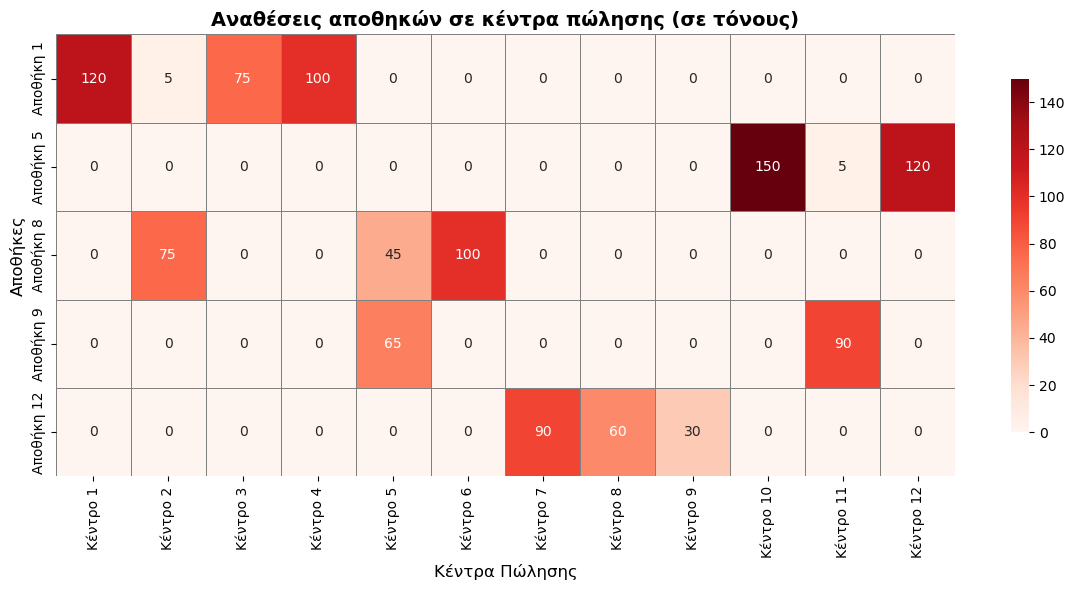

In [80]:
def plot_heatmap(supply, warehouses, centers):
    flows = [(i + 1, j + 1, supply[i, j].X)
             for i in warehouses
             for j in centers
             if supply[i, j].X > 1e-6]

    active_warehouses = sorted(set(i for i, j, _ in flows))
    active_centers = sorted(set(j for i, j, _ in flows))

    flow_matrix = np.zeros((len(active_warehouses), len(active_centers)))
    for i, j, val in flows:
        i_idx = active_warehouses.index(i)
        j_idx = active_centers.index(j)
        flow_matrix[i_idx, j_idx] = val

    warehouse_labels = [f"Αποθήκη {i}" for i in active_warehouses]
    center_labels = [f"Κέντρο {j}" for j in active_centers]

    plt.figure(figsize=(12, 6))
    sns.heatmap(flow_matrix, annot=True, fmt=".0f", cmap="Reds",
                xticklabels=center_labels, yticklabels=warehouse_labels,
                linewidths=0.5, linecolor='gray', cbar_kws={"shrink": 0.8})

    plt.title("Αναθέσεις αποθηκών σε κέντρα πώλησης (σε τόνους)", fontsize=14, weight='bold')
    plt.ylabel("Αποθήκες", fontsize=12)
    plt.xlabel("Κέντρα Πώλησης", fontsize=12)
    plt.tight_layout()
    plt.show()

warehouses = range(num_warehouses)
centers = range(num_customers)
plot_heatmap(supply, warehouses, centers)
